# <span style="color:blue">Developing, Training, and Deploying a TensorFlow model on Google Cloud Platform</span> 

**Import Libraries**

In [1]:
import pandas as pd
from io import BytesIO
import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
sns.set()

import datalab.storage as storage

## 1. Setting up Cloud Environment on your GCP Project 

**Change to your bucket and project name, to set up environment in your project, store files in your bucket and to run the model on cloud ml engine**

In [2]:
#Make sure you put the correct values here !!!
BUCKET='usc-demo'         #Change it based on the name of your GCS Bucket
PROJECT='usc-demo-class'  #Change it to your Project Name
REGION='us-west1'         #Look at the Region mentioned in details of the Bucket

In [3]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

## 2. Data Preprocessing

**Select the data file, date and the target variables that you want to use for the revenue forecast**

In [4]:
data_file='data.csv'    #Name of the data File
date='date_of_sale'
target='net_sales'

In [5]:
data = pd.read_csv(data_file, parse_dates=[date])

In [6]:
data = data[data.upc == 25097000000]
data.head()

,Unnamed: 0,Unnamed: 0.1,upc,date_of_sale,store_id,departmentname,categoryname,net_sales,count
0,0,13624305,25097000000,2017-11-22,2,Bakery,Viktor Benes/ Renaud Bakery,12.28,790168
1,1,13624306,25097000000,2017-01-30,2,Bakery,Viktor Benes/ Renaud Bakery,9.50,790168
2,2,13624307,25097000000,2016-04-11,2,Bakery,Viktor Benes/ Renaud Bakery,2.75,790168
3,3,13624308,25097000000,2017-07-02,2,Bakery,Viktor Benes/ Renaud Bakery,8.77,790168
4,4,13624309,25097000000,2018-05-07,2,Bakery,Viktor Benes/ Renaud Bakery,11.45,790168


In [7]:
upc_code = data.upc[0]
departmentname = data.departmentname[0]
print(upc_code,departmentname)

25097000000 Bakery


In [8]:
data = data[[date, target]]

In [9]:
data = data.set_index(data[date])

In [10]:
data = data.drop(columns = [date])

In [11]:
data = data["net_sales"].resample("D").sum()

In [12]:
data = data.to_frame()

In [13]:
data.head()

,net_sales
date_of_sale,
2016-01-03,8223.23
2016-01-04,7021.80
2016-01-05,6610.42
2016-01-06,6445.34
2016-01-07,7195.91


In [14]:
def data_prep(data):
    data_np = data.values
    train = []
    for i in range(90, len(data_np)):
        train.append(data_np[i-90:i])
        
    list_zero = train[0]
    df = pd.DataFrame(list_zero).T
    
    for i in range(1, len(train)):
        a = train[i]
        b = pd.DataFrame(a).T
        b.index = [i]
        df = pd.concat((df, b), axis = 0)
        
    ind = int(0.8*len(df))
    train = df[:ind]
    eval_ = df[ind:]
    test = eval_.iloc[-1]
    test = test[30:]
    
    
    last_date = data[-30:-29]
    last_date = last_date.index
    
    dates = []
    for i in range(0, 60):
        temp = last_date + timedelta(days = 1)
        dates.append(last_date)
        last_date = temp
    dates = pd.DataFrame(dates)
    
    return train, eval_, test, dates

In [15]:
train, eval_, test, dates = data_prep(data)

In [16]:
test = test.tolist()

In [17]:
train.to_csv("train.csv", index = False, header = False)
eval_.to_csv("eval.csv", index = False, header = False)

In [18]:
storage.Bucket(BUCKET).item('data/train.csv').write_to(train.to_csv(index=False, header=False),'text/csv')
storage.Bucket(BUCKET).item('data/eval.csv').write_to(eval_.to_csv(index=False, header=False),'text/csv')

## Train Locally

In [19]:
import trainer

In [20]:
%%bash
rm -rf cnnmodel
python -m trainer.task \
  --train_data_paths=gs://${BUCKET}/data/train.csv \
  --eval_data_paths=gs://${BUCKET}/data/eval.csv \
  --output_dir=cnnmodel \
  --job-dir=./tmp \
  --train_steps=1

W0711 21:15:01.961075 140694949987776 deprecation_wrapper.py:119] From trainer/model.py:20: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0711 21:15:01.961416 140694949987776 deprecation_wrapper.py:119] From trainer/model.py:20: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

I0711 21:15:01.964379 140694949987776 estimator.py:209] Using config: {'_save_checkpoints_secs': 60, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5dfe41ed0>, '_model_dir': 'cnnmodel/', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_step

## 3. Train in Cloud ML 

In [21]:
%%bash
SEQ_LEN=90
gsutil rm -r gs://${BUCKET}/out/trained
JOBNAME=uscdemo_$(date -u +%y%m%d_%H%M%S)
gcloud ai-platform jobs submit training $JOBNAME \
  --job-dir=gs://${BUCKET}/out/trained \
  --package-path=${PWD}/trainer \
  --module-name=trainer.task \
  --region=us-west1 \
  --runtime-version=1.8 \
  --scale-tier=BASIC \
  -- \
  --train_data_paths=gs://${BUCKET}/data/train.csv \
  --eval_data_paths=gs://${BUCKET}/data/eval.csv  \
  --output_dir=gs://${BUCKET}/out/trained

jobId: uscdemo_190711_211710
state: QUEUED


CommandException: No URLs matched: gs://usc-demo/out/trained
Job [uscdemo_190711_211710] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe uscdemo_190711_211710

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs uscdemo_190711_211710


**Run below lines to see the Hyperparameter Tuning**

In [27]:
#%%bash
#gcloud ai-platform jobs describe demandml_190523_151932_v19

## 4. Create and Delploy the trained job on model 

**Run it only after your Job has completed running**

In [22]:
%%bash
REGION='us-west1'
MODEL_NAME=revenueml_$(date -u +%y%m%d_%H%M%S)
MODEL_VERSION="v1"
gcloud ml-engine models create $MODEL_NAME
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/out/trained/export/exporter/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"

gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version 1.8

Deleting and deploying revenueml_190711_212322 v1 from gs://usc-demo/out/trained/export/exporter/1562880084/ ... this will take a few minutes


Created ml engine model [projects/usc-demo-class/models/revenueml_190711_212322].
Creating version (this might take a few minutes)......
......................................................................................................................................................................................................................................................................................................done.


**THE MODEL IS DEPLOYED .... YAYYY !!!**

## Cloud ML Prediction

*You might see some errors after running it, but as long as your model is deployed, you can ignore them*

In [25]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

MODEL_NAME = 'revenueml_190711_212322'  #Change the Model name here, Put the name of your Model !!!
print(MODEL_NAME)

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)

test = test
request_data = {"instances": [test]}

 
parent = 'projects/%s/models/%s/versions/%s' % (PROJECT,MODEL_NAME, 'v1')
response = api.projects().predict(body = request_data, name = parent).execute()
#print "response={0}".format(response)

W0711 21:26:37.274626 139935977514752 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.5/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ImportError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.5/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ImportError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.5/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_fi

revenueml_190711_212322


## Checking for Predictions using ML Model on GCP

In [27]:
a = response["predictions"] 

In [28]:
dictlist=[] 

In [29]:
for key, value in a[0].items():
    temp = [key,value]
    dictlist.append(temp)

In [30]:
predicted = data[-30:]
predicted = pd.DataFrame(predicted)
predicted.reset_index(drop=True, inplace=True)

In [31]:
a = dictlist[0]
a = a[1]
a = pd.DataFrame(a)

In [33]:
frames = (date,predicted,a)
result = pd.concat((dates,predicted,a), axis = 1)
result.columns = ["DATE", "ACTUAL","FORECAST"]
forecast_df = result
forecast_df = forecast_df.round()
forecast_df = forecast_df.fillna(0)
for i in range(0, len(forecast_df)):
    if forecast_df.FORECAST[i] <= 0:
        forecast_df.FORECAST[i] = 0
forecast_df.head()

,DATE,ACTUAL,FORECAST
0,2018-08-02,7985.0,6059.0
1,2018-08-03,11410.0,7848.0
2,2018-08-04,22748.0,9374.0
3,2018-08-05,17623.0,9428.0
4,2018-08-06,14273.0,7677.0


In [34]:
upc_list = []
departmentname_list = []

for i in range(0, 60):
    upc_list.append(upc_code)
    departmentname_list.append(departmentname)
    
details_df = pd.DataFrame({
    "upc_code": upc_list,
    "departmentname": departmentname_list
})

final_df = pd.concat((details_df, forecast_df), axis = 1)
final_df.head()

,departmentname,upc_code,DATE,ACTUAL,FORECAST
0,Bakery,25097000000,2018-08-02,7985.0,6059.0
1,Bakery,25097000000,2018-08-03,11410.0,7848.0
2,Bakery,25097000000,2018-08-04,22748.0,9374.0
3,Bakery,25097000000,2018-08-05,17623.0,9428.0
4,Bakery,25097000000,2018-08-06,14273.0,7677.0


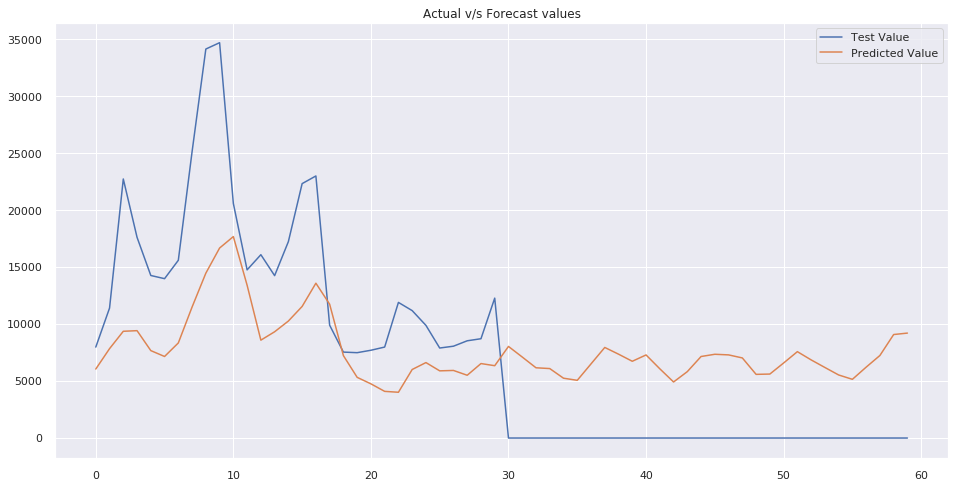

In [35]:
plt.figure(figsize=(16,8))
plt.plot(final_df.ACTUAL, label = "Test Value")
plt.plot(final_df.FORECAST, label = "Predicted Value")
plt.title("Actual v/s Forecast values")
plt.legend()
plt.show()

## Save forecast file to storage bucket

In [36]:
final_df.to_csv("forecast.csv")

In [48]:
final_df.head()

,departmentname,upc_code,DATE,ACTUAL,FORECAST
0,Bakery,25097000000,2018-08-02,7985.0,12281.0
1,Bakery,25097000000,2018-08-03,11410.0,13427.0
2,Bakery,25097000000,2018-08-04,22748.0,16572.0
3,Bakery,25097000000,2018-08-05,17623.0,21985.0
4,Bakery,25097000000,2018-08-06,14273.0,19316.0


**Save the Predictions file on GCS**

In [37]:
!gsutil cp -r forecast.csv gs://usc-demo/

Copying file://forecast.csv [Content-Type=text/csv]...
/ [1 files][  2.7 KiB/  2.7 KiB]                                                
Operation completed over 1 objects/2.7 KiB.                                      
